In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
import seaborn as sns
import scipy.stats as stats
import random

In [2]:
def compute_chi(data):
    '''
    Computes the value of Chi, a synchrony measurement that compares the variance of individual voltage traces and the variance of the mean of the voltages.

    Parameters:
        data (list[float]):
            Voltage traces with each row corresponding one neuron.

    Returns:
        chi (float):
            The value of Chi.
    '''

    #calculate the average voltage as a function of time
    mean_voltage = np.mean(data,axis=0)

    #calculate the variance of each trave and the average voltage
    ind_variance = np.mean(np.square(data),axis=1) - np.mean(data,axis=1)**2
    total_variance = np.mean(np.square(mean_voltage)) - np.mean(mean_voltage)**2

    #calculate chi
    chi = np.sqrt(total_variance**2 / np.mean(ind_variance**2))

    return chi 


findfont: Font family ['Times'] not found. Falling back to DejaVu Sans.


Average number of connections per neuron: 39.56
Connectivity Matrix g [[0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.33022684 ... 0.         0.41722493 0.        ]
 [0.         0.3561603  0.         ... 0.         0.         0.        ]
 ...
 [0.31972699 0.         0.         ... 0.         0.         0.        ]
 [0.         0.43372646 0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]]
Average value of matrix g= 0.049546704329874756


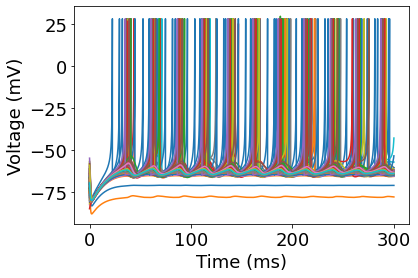

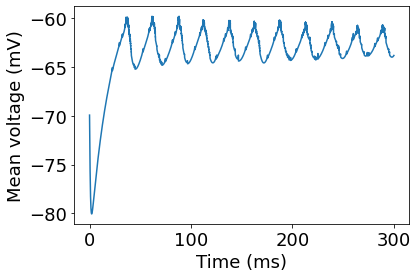

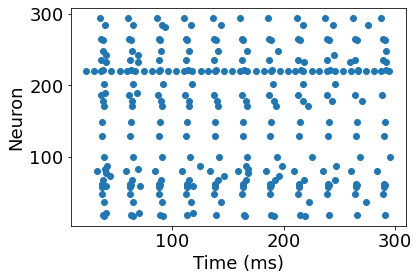

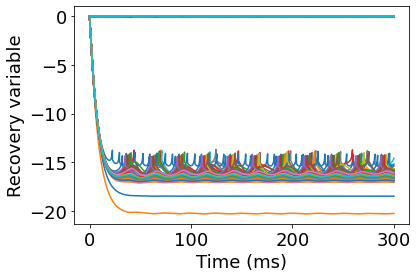

In [3]:
# Making neuron sparsely connected for second order synaptic term
# Has identical code to paper except different synaptic term (2nd order given by Aine)
# Changed the synaptic coupling to be probabilistic
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
import seaborn as sns
import scipy.stats as stats
import random

np.random.seed(101)

N = 300
T = 300
M = 50000
dt = 0.005
t0 = 0

k = 1
a = 0.1
b = 0.26
c = -65
d = -1
v_reset = c
v_thresh = 30

Esyn = -70
tauS = 3.043043043043043

J = np.random.normal(0, 0.25, size=(N))

I0 = 0.15
delta = 0.02  
I = stats.cauchy.rvs(loc=I0, scale=delta, size=(N))

# Define desired average number of connections
Avg_Connections = 40
connection_probability = Avg_Connections / N

# Initialize the synaptic coupling matrix
g = np.zeros((N, N))

# Sparsely connected networks with probabilistic connections
for j in range(N):
    for i in range(N):
        if i != j:  # Avoid self-connections
            if np.random.rand() < connection_probability:
                g[j, i] = np.random.uniform(0.25, 0.5)  # Set random connection strength 

# All-to-all connectivity
# g = np.random.uniform(0.05, 0.5, size=(N, N))
# np.fill_diagonal(g, 0)  # Set diagonal to zero to avoid self-connections



v_init = np.random.normal(-70, 5, size=(N))
u_init = np.zeros(N)
s_init = np.zeros(N)
p_init = np.zeros(N)

t_all = np.array([t0])
y_0 = np.concatenate([v_init, u_init, s_init, p_init])
y_all = np.reshape(y_0, (y_0.shape[0], 1))

spike_times = np.zeros((M, 2))
spikeCounter = 0
i = 0

def dxdt(t, x, k, a, b, I, Esyn, J, tauS):
    v = x[:N]
    u = x[N:2*N]
    s = x[2*N:3*N]
    p = x[3*N:4*N]
    
    dvdt = k * (0.04 * v**2 + 5 * v + 140 - u + I) + J - (v - Esyn) * np.dot(g,s)
    dudt = k * a * (b * v - u)
    dsdt = -s / tauS + p / tauS
    dpdt = -p / tauS
    
    return np.concatenate([dvdt, dudt, dsdt, dpdt])

# Spike event
def v_spike(t, x, k, a, b, I, Esyn, J, tauS):
    return x[:N].max() - v_thresh
v_spike.terminal = True
v_spike.direction = 1

# Set up spike time vector
spike_times = np.zeros((M, 2))
spikeCounter = 0    
i = 0

# Simulation loop
while i < M and t0 < T:
    y0 = np.concatenate([v_init, u_init, s_init, p_init])  
   
    sol_v = solve_ivp(dxdt, [t0, T], y0, args=(k, a, b, I, Esyn, J, tauS), dense_output=True, 
                      events=v_spike, rtol=1e-8)
    
    t_end = sol_v.t[-1]
    steps = max([2, int((t_end - t0) / dt)])
    t = np.linspace(t0, t_end, steps)
    y = sol_v.sol(t)
    
    t_all = np.concatenate([t_all, t[:-1]], axis=0)
    y_all = np.concatenate([y_all, y[:, :-1]], axis=1)
    
    t0 = t_end
    v_init = y[:N, -1]
    u_init = y[N:2*N, -1]
    s_init = y[2*N:3*N, -1]
    p_init = y[3*N:4*N, -1]
    
    if len(sol_v.t_events[0]) > 0:
        spike = v_init.argmax()
        v_init[spike] = v_reset
        u_init[spike] += d
        p_init += 1 / (tauS * N)
        
        spike_times[spikeCounter, :] = [t0, spike]
        spikeCounter = spikeCounter + 1
        i += 1

colours = sns.color_palette('deep')
font = {'family': 'Times', 'weight': 'normal', 'size': 18}
plt.rc('font', **font)

plt.figure()
plt.plot(t_all, y_all[:N, :].T)
plt.xlabel('Time (ms)')
plt.ylabel('Voltage (mV)')

plt.figure()
plt.plot(t_all, y_all[:N, :].mean(axis=0))
plt.xlabel('Time (ms)')
plt.ylabel('Mean voltage (mV)')

spike_times = spike_times[:spikeCounter, :]
plt.figure()
plt.scatter(spike_times[:, 0], spike_times[:, 1])
plt.xlabel('Time (ms)')
plt.ylabel('Neuron')

plt.figure()
plt.plot(t_all, y_all[N:, :].T)
plt.xlabel('Time (ms)')
plt.ylabel('Recovery variable')



# Count the number of non-zero entries in each row
connections_per_neuron = np.count_nonzero(g, axis=1)

# Calculate the average number of connections per neuron
average_connections = np.mean(connections_per_neuron)

print(f"Average number of connections per neuron: {average_connections}")
print("Connectivity Matrix g", g)
print("Average value of matrix g=", np.mean(g))

In [4]:
# Something in Aines initial code which fixes the issue for neuron 0
# Initialize a dictionary to store spike times for each neuron
neuron_spike_times = {i: [] for i in range(N)}

# Iterate through the spike_times array
for time, neuron in spike_times:
    if neuron < N:  # Ensure neuron index is within range 0-299
        neuron_spike_times[int(neuron)].append(time)

# Display spike times for each neuron
for neuron, times in neuron_spike_times.items():
    print(f"Neuron {neuron} spike times: {times}")


Neuron 0 spike times: []
Neuron 1 spike times: []
Neuron 2 spike times: []
Neuron 3 spike times: []
Neuron 4 spike times: []
Neuron 5 spike times: []
Neuron 6 spike times: []
Neuron 7 spike times: []
Neuron 8 spike times: []
Neuron 9 spike times: []
Neuron 10 spike times: []
Neuron 11 spike times: []
Neuron 12 spike times: []
Neuron 13 spike times: []
Neuron 14 spike times: []
Neuron 15 spike times: []
Neuron 16 spike times: []
Neuron 17 spike times: [38.38523031672463, 64.80648545429858, 91.9098628153612, 164.88236193244884, 191.04091016545402, 219.28422386686708]
Neuron 18 spike times: [37.90173795349375, 63.07704793847784, 88.94775244104446, 113.56451329357286, 139.0028093427564, 164.00448308571447, 188.81589513552126, 214.4748023118213, 240.4639174639559, 265.85009062742625, 290.95686582125035]
Neuron 19 spike times: []
Neuron 20 spike times: []
Neuron 21 spike times: [40.19185161939996, 70.25799758945519, 118.34511787107657]
Neuron 22 spike times: []
Neuron 23 spike times: []
Neur

findfont: Font family ['Times'] not found. Falling back to DejaVu Sans.


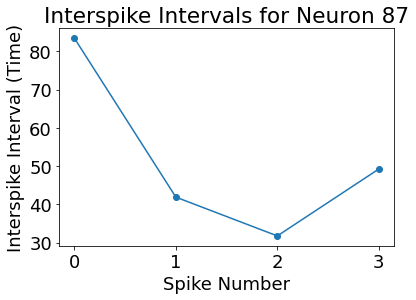

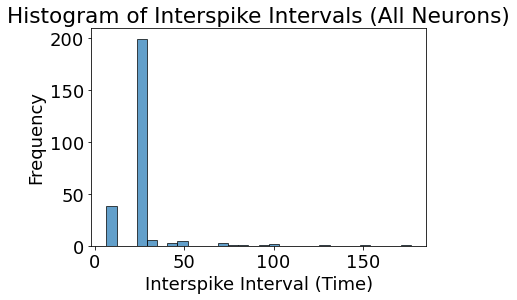

In [5]:
import matplotlib.pyplot as plt

# Calculate interspike intervals (ISIs) for each neuron
interspike_intervals = {neuron: [] for neuron in neuron_spike_times}

for neuron, times in neuron_spike_times.items():
    if len(times) > 1:  # Need at least two spikes to calculate ISI
        interspike_intervals[neuron] = [times[i+1] - times[i] for i in range(len(times)-1)]

# Plot ISIs for a specific neuron (e.g., Neuron 0)
neuron_to_plot = 87
if interspike_intervals[neuron_to_plot]:
    plt.figure()
    plt.plot(interspike_intervals[neuron_to_plot], marker='o')
    plt.title(f"Interspike Intervals for Neuron {neuron_to_plot}")
    plt.xlabel("Spike Number")
    plt.ylabel("Interspike Interval (Time)")
    plt.show()
else:
    print(f"Neuron {neuron_to_plot} has no ISIs to plot.")

# Histogram of ISIs for all neurons
all_isis = [isi for neuron_isis in interspike_intervals.values() for isi in neuron_isis]
if all_isis:
    plt.figure()
    plt.hist(all_isis, bins=30, alpha=0.7, edgecolor='k')
    plt.title("Histogram of Interspike Intervals (All Neurons)")
    plt.xlabel("Interspike Interval (Time)")
    plt.ylabel("Frequency")
    plt.show()
else:
    print("No ISIs found across neurons to plot.")


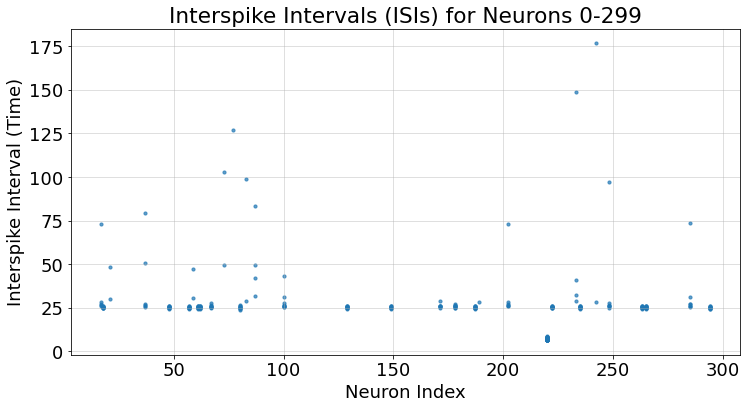

In [6]:
import matplotlib.pyplot as plt

# Prepare data for the scatter plot
x_neurons = []
y_isis = []

for neuron, isis in interspike_intervals.items():
    x_neurons.extend([neuron] * len(isis))  # Repeat neuron index for each ISI
    y_isis.extend(isis)  # Add all ISIs for this neuron

# Scatter plot
plt.figure(figsize=(12, 6))
plt.scatter(x_neurons, y_isis, alpha=0.7, s=10)  # Small points for better clarity
plt.title("Interspike Intervals (ISIs) for Neurons 0-299")
plt.xlabel("Neuron Index")
plt.ylabel("Interspike Interval (Time)")
plt.grid(alpha=0.5)
plt.show()


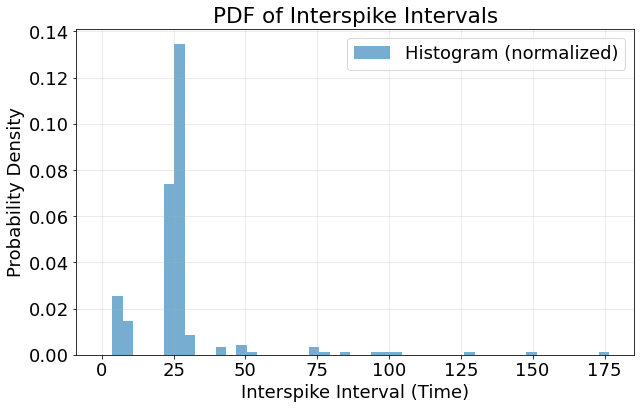

Total area under histogram: 0.9999999999999998


In [7]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde

# Assume `interspike_intervals` is a dictionary with neuron indices as keys and lists of ISIs as values
all_isis = []
for isis in interspike_intervals.values():
    all_isis.extend(isis)  # Aggregate all ISIs across neurons

# Convert ISIs to a numpy array
all_isis = np.array(all_isis)

# Generate histogram and normalize to form a PDF
bin_edges = np.linspace(0, np.max(all_isis), 50)  # Adjust bins as needed
hist, bin_edges = np.histogram(all_isis, bins=bin_edges, density=True)

# Smooth PDF using Kernel Density Estimation (KDE)
kde = gaussian_kde(all_isis)
x_vals = np.linspace(0, np.max(all_isis), 500)
pdf_vals = kde(x_vals)

# Plot the PDF
plt.figure(figsize=(10, 6))
plt.hist(all_isis, bins=bin_edges, density=True, alpha=0.6, label='Histogram (normalized)')
plt.title("PDF of Interspike Intervals")
plt.xlabel("Interspike Interval (Time)")
plt.ylabel("Probability Density")
plt.legend()
plt.grid(alpha=0.3)
plt.show()
# Histogram computation with density=True
hist, bin_edges = np.histogram(all_isis, bins=50, density=True)

# Calculate the total area under the histogram
bin_widths = np.diff(bin_edges)  # Calculate the width of each bin
total_area = np.sum(hist * bin_widths)  # Sum of (height * width) for each bar

print(f"Total area under histogram: {total_area}")  # Should print approximately 1


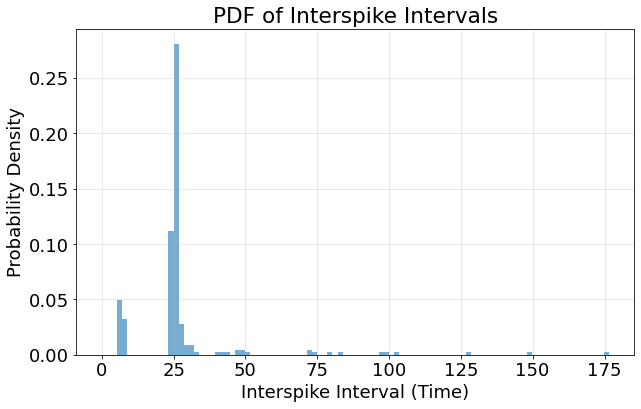

Total area under histogram: 0.9999999999999998
Width of each bin: [1.78374207 1.78374207 1.78374207 1.78374207 1.78374207 1.78374207
 1.78374207 1.78374207 1.78374207 1.78374207 1.78374207 1.78374207
 1.78374207 1.78374207 1.78374207 1.78374207 1.78374207 1.78374207
 1.78374207 1.78374207 1.78374207 1.78374207 1.78374207 1.78374207
 1.78374207 1.78374207 1.78374207 1.78374207 1.78374207 1.78374207
 1.78374207 1.78374207 1.78374207 1.78374207 1.78374207 1.78374207
 1.78374207 1.78374207 1.78374207 1.78374207 1.78374207 1.78374207
 1.78374207 1.78374207 1.78374207 1.78374207 1.78374207 1.78374207
 1.78374207 1.78374207 1.78374207 1.78374207 1.78374207 1.78374207
 1.78374207 1.78374207 1.78374207 1.78374207 1.78374207 1.78374207
 1.78374207 1.78374207 1.78374207 1.78374207 1.78374207 1.78374207
 1.78374207 1.78374207 1.78374207 1.78374207 1.78374207 1.78374207
 1.78374207 1.78374207 1.78374207 1.78374207 1.78374207 1.78374207
 1.78374207 1.78374207 1.78374207 1.78374207 1.78374207 1.78374

In [8]:
# Generate histogram and normalize to form a PDF with smaller bins
bin_edges = np.linspace(0, np.max(all_isis), 100)  # Increase the number of bins for finer granularity
hist, bin_edges = np.histogram(all_isis, bins=bin_edges, density=True)


# Plot the PDF
plt.figure(figsize=(10, 6))
plt.hist(all_isis, bins=bin_edges, density=True, alpha=0.6)

plt.title("PDF of Interspike Intervals")
plt.xlabel("Interspike Interval (Time)")
plt.ylabel("Probability Density")
plt.grid(alpha=0.3)
plt.show()

# Calculate the total area under the histogram
bin_widths = np.diff(bin_edges)  # Calculate the width of each bin
total_area = np.sum(hist * bin_widths)  # Sum of (height * width) for each bar

print(f"Total area under histogram: {total_area}")  # Should print approximately 1
# Calculate the bin widths
bin_widths = np.diff(bin_edges)  # Difference between consecutive bin edges
print(f"Width of each bin: {bin_widths}")


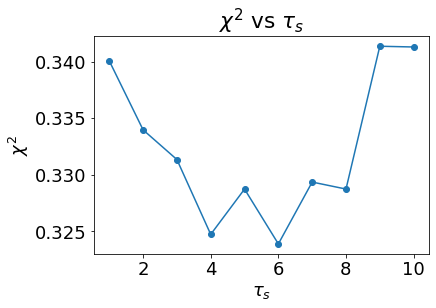

In [9]:
# Define the range of tau_s values
tau_s_values = np.arange(1, 11, 1)  # Values from 0 to 10 inclusive
chi_sq_values = []

# Loop over different values of tau_s
for tau_s in tau_s_values:
    # Reinitialize initial conditions for each tau_s run
    v_init = np.random.normal(-70, 5, size=(N))
    u_init = np.zeros(N)
    s_init = np.zeros(N)
    p_init = np.zeros(N)
    
    t_all = np.array([t0])
    y_0 = np.concatenate([v_init, u_init, s_init, p_init])
    y_all = np.reshape(y_0, (y_0.shape[0], 1))
    
    spike_times = np.zeros((M, 2))
    spikeCounter = 0
    i = 0
    t0 = 0  # Reset simulation start time

    # Simulation loop with new tau_s
    while i < M and t0 < T:
        y0 = np.concatenate([v_init, u_init, s_init, p_init])  

        # Use solve_ivp with current tau_s
        sol_v = solve_ivp(dxdt, [t0, T], y0, args=(k, a, b, I, Esyn, J, tau_s), dense_output=True, 
                          events=v_spike, rtol=1e-8)

        t_end = sol_v.t[-1]
        steps = max([2, int((t_end - t0) / dt)])
        t = np.linspace(t0, t_end, steps)
        y = sol_v.sol(t)
        
        t_all = np.concatenate([t_all, t[:-1]], axis=0)
        y_all = np.concatenate([y_all, y[:, :-1]], axis=1)

        t0 = t_end
        v_init = y[:N, -1]
        u_init = y[N:2*N, -1]
        s_init = y[2*N:3*N, -1]
        p_init = y[3*N:4*N, -1]

        if len(sol_v.t_events[0]) > 0:
            spike = v_init.argmax()
            v_init[spike] = v_reset
            u_init[spike] += d
            p_init += 1 / (tau_s * N) if tau_s > 0 else 0  # Avoid division by zero for tau_s=0
            
            spike_times[spikeCounter, :] = [t0, spike]
            spikeCounter = spikeCounter + 1
            i += 1

    # Compute chi_sq for current tau_s
    data = y_all[:N, :]
    chi_sq = compute_chi(data)
    chi_sq_values.append(chi_sq)

# Plotting the results
plt.figure()
plt.plot(tau_s_values, chi_sq_values, marker='o', linestyle='-')
plt.xlabel(r'$\tau_s$')
plt.ylabel(r'$\chi^2$')
plt.title(r'$\chi^2$ vs $\tau_s$')
plt.show()


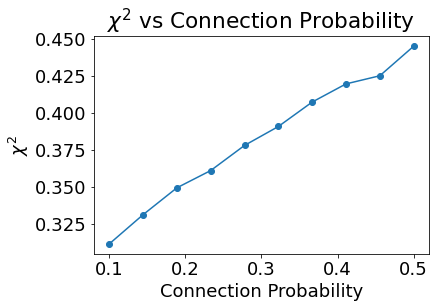

In [10]:
# Define different connectivity parameters for g
connection_probs = np.linspace(0.1, 0.5, 10)  # Vary connection probability from 0.1 to 0.5
chi_sq_values = []

# Loop over different values of connection probability for g
for conn_prob in connection_probs:
    # Initialize synaptic coupling matrix with new connection probability
    g = np.zeros((N, N))
    for j in range(N):
        for i in range(N):
            if i != j:  # Avoid self-connections
                if np.random.rand() < conn_prob:
                    g[j, i] = np.random.uniform(0.25, 0.5)  # Set random connection strength

    # Reinitialize initial conditions for each g matrix run
    v_init = np.random.normal(-70, 5, size=(N))
    u_init = np.zeros(N)
    s_init = np.zeros(N)
    p_init = np.zeros(N)
    
    t_all = np.array([t0])
    y_0 = np.concatenate([v_init, u_init, s_init, p_init])
    y_all = np.reshape(y_0, (y_0.shape[0], 1))
    
    spike_times = np.zeros((M, 2))
    spikeCounter = 0
    i = 0
    t0 = 0  # Reset simulation start time

    # Simulation loop with the current synaptic coupling matrix g
    while i < M and t0 < T:
        y0 = np.concatenate([v_init, u_init, s_init, p_init])  

        # Use solve_ivp with current g matrix
        sol_v = solve_ivp(dxdt, [t0, T], y0, args=(k, a, b, I, Esyn, J, tauS), dense_output=True, 
                          events=v_spike, rtol=1e-8)

        t_end = sol_v.t[-1]
        steps = max([2, int((t_end - t0) / dt)])
        t = np.linspace(t0, t_end, steps)
        y = sol_v.sol(t)
        
        t_all = np.concatenate([t_all, t[:-1]], axis=0)
        y_all = np.concatenate([y_all, y[:, :-1]], axis=1)

        t0 = t_end
        v_init = y[:N, -1]
        u_init = y[N:2*N, -1]
        s_init = y[2*N:3*N, -1]
        p_init = y[3*N:4*N, -1]

        if len(sol_v.t_events[0]) > 0:
            spike = v_init.argmax()
            v_init[spike] = v_reset
            u_init[spike] += d
            p_init += 1 / (tauS * N) if tauS > 0 else 0  # Avoid division by zero if tauS=0
            
            spike_times[spikeCounter, :] = [t0, spike]
            spikeCounter = spikeCounter + 1
            i += 1

    # Compute chi_sq for the current g matrix
    data = y_all[:N, :]
    chi_sq = compute_chi(data)
    chi_sq_values.append(chi_sq)

# Plotting the results
plt.figure()
plt.plot(connection_probs, chi_sq_values, marker='o', linestyle='-')
plt.xlabel('Connection Probability')
plt.ylabel(r'$\chi^2$')
plt.title(r'$\chi^2$ vs Connection Probability')
plt.show()


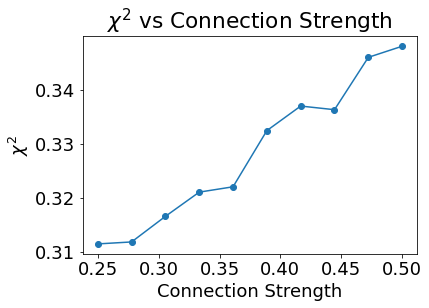

In [11]:
# Define different connectivity parameters for g
connection_strengths = np.linspace(0.25, 0.5, 10)  # Vary connection strength from 0.25 to 0.5
chi_sq_values = []

# Loop over different values of connection strength for g
for conn_strength in connection_strengths:
    # Initialize synaptic coupling matrix with new connection strength
    g = np.zeros((N, N))
    for j in range(N):
        for i in range(N):
            if i != j:  # Avoid self-connections
                if np.random.rand() < 40/300:  # Fixed probability for connection, e.g., 0.3
                    g[j, i] = conn_strength  # Set connection to the current strength value

    # Reinitialize initial conditions for each g matrix run
    v_init = np.random.normal(-70, 1, size=(N))
    u_init = np.zeros(N)
    s_init = np.zeros(N)
    p_init = np.zeros(N)
    
    t_all = np.array([t0])
    y_0 = np.concatenate([v_init, u_init, s_init, p_init])
    y_all = np.reshape(y_0, (y_0.shape[0], 1))
    
    spike_times = np.zeros((M, 2))
    spikeCounter = 0
    i = 0
    t0 = 0  # Reset simulation start time

    # Simulation loop with the current synaptic coupling matrix g
    while i < M and t0 < T:
        y0 = np.concatenate([v_init, u_init, s_init, p_init])  

        # Use solve_ivp with current g matrix
        sol_v = solve_ivp(dxdt, [t0, T], y0, args=(k, a, b, I, Esyn, J, tauS), dense_output=True, 
                          events=v_spike, rtol=1e-8)

        t_end = sol_v.t[-1]
        steps = max([2, int((t_end - t0) / dt)])
        t = np.linspace(t0, t_end, steps)
        y = sol_v.sol(t)
        
        t_all = np.concatenate([t_all, t[:-1]], axis=0)
        y_all = np.concatenate([y_all, y[:, :-1]], axis=1)

        t0 = t_end
        v_init = y[:N, -1]
        u_init = y[N:2*N, -1]
        s_init = y[2*N:3*N, -1]
        p_init = y[3*N:4*N, -1]

        if len(sol_v.t_events[0]) > 0:
            spike = v_init.argmax()
            v_init[spike] = v_reset
            u_init[spike] += d
            p_init += 1 / (tauS * N) if tauS > 0 else 0  # Avoid division by zero if tauS=0
            
            spike_times[spikeCounter, :] = [t0, spike]
            spikeCounter = spikeCounter + 1
            i += 1

    # Compute chi_sq for the current g matrix
    data = y_all[:N, :]
    chi_sq = compute_chi(data)
    chi_sq_values.append(chi_sq)

# Plotting the results
plt.figure()
plt.plot(connection_strengths, chi_sq_values, marker='o', linestyle='-')
plt.xlabel('Connection Strength')
plt.ylabel(r'$\chi^2$')
plt.title(r'$\chi^2$ vs Connection Strength')
plt.show()


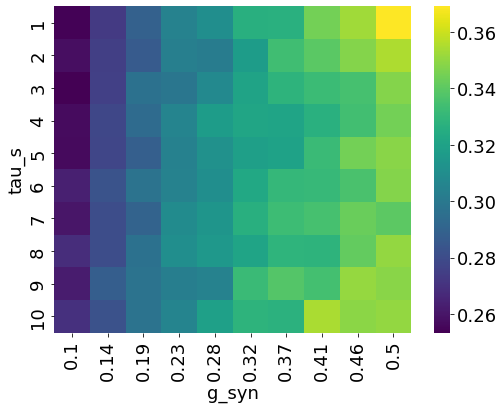

In [12]:
tau_s_values = np.arange(1, 11, 1)  
g_syn_values = np.linspace(0.1, 0.5, 10)  

chi_sq_matrix = np.zeros((len(tau_s_values), len(g_syn_values)))

for i, tau_s in enumerate(tau_s_values):
    for j, g_syn in enumerate(g_syn_values):
        g = np.zeros((N, N))
        for row in range(N):
            for col in range(N):
                if row != col:  
                    if np.random.rand() < connection_probability:
                        g[row, col] = np.random.uniform(g_syn - 0.1, g_syn + 0.1)  

        v_init = np.random.normal(-70, 5, size=(N))
        u_init = np.zeros(N)
        s_init = np.zeros(N)
        p_init = np.zeros(N)
        
        t_all = np.array([t0])
        y_0 = np.concatenate([v_init, u_init, s_init, p_init])
        y_all = np.reshape(y_0, (y_0.shape[0], 1))
        
        spike_times = np.zeros((M, 2))
        spikeCounter = 0
        t0 = 0  
        i_step = 0

        while i_step < M and t0 < T:
            y0 = np.concatenate([v_init, u_init, s_init, p_init])  

            
            sol_v = solve_ivp(dxdt, [t0, T], y0, args=(k, a, b, I, Esyn, J, tau_s), dense_output=True, 
                              events=v_spike, rtol=1e-8)

            t_end = sol_v.t[-1]
            steps = max([2, int((t_end - t0) / dt)])
            t = np.linspace(t0, t_end, steps)
            y = sol_v.sol(t)
            
            t_all = np.concatenate([t_all, t[:-1]], axis=0)
            y_all = np.concatenate([y_all, y[:, :-1]], axis=1)

            t0 = t_end
            v_init = y[:N, -1]
            u_init = y[N:2*N, -1]
            s_init = y[2*N:3*N, -1]
            p_init = y[3*N:4*N, -1]

            if len(sol_v.t_events[0]) > 0:
                spike = v_init.argmax()
                v_init[spike] = v_reset
                u_init[spike] += d
                p_init += 1 / (tau_s * N) if tau_s > 0 else 0
                
                spike_times[spikeCounter, :] = [t0, spike]
                spikeCounter = spikeCounter + 1
                i_step += 1

        data = y_all[:N, :]
        chi_sq = compute_chi(data)
        chi_sq_matrix[i, j] = chi_sq

plt.figure(figsize=(8, 6))
sns.heatmap(chi_sq_matrix, xticklabels=np.round(g_syn_values, 2), yticklabels=tau_s_values, cmap='viridis')
plt.xlabel('g_syn')
plt.ylabel('tau_s')
plt.show()


Average number of connections per neuron: 39.57
Connectivity Matrix g [[0.         0.42384853 0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.37565821 0.        ]
 ...
 [0.         0.         0.30169669 ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.38595867 0.26713488 ... 0.         0.         0.        ]]
Average value of matrix g= 0.04954971408890521


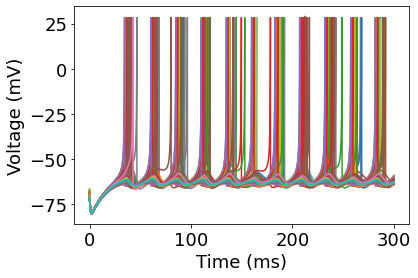

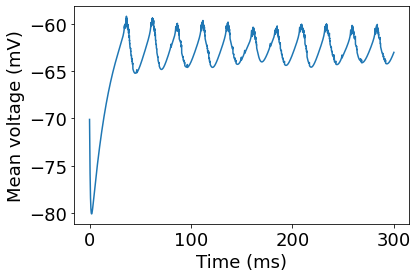

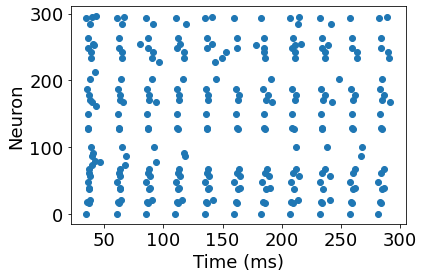

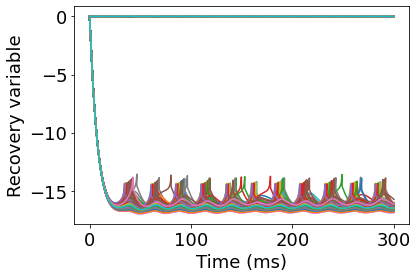

In [13]:
# Making neuron sparsely connected for second order synaptic term
# Has identical code to paper except different synaptic term (2nd order given by Aine)
# Changed the synaptic coupling to be probabilistic
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
import seaborn as sns
import scipy.stats as stats
import random

np.random.seed(101)

N = 300
T = 300
M = 50000
dt = 0.005
t0 = 0

k = 1
a = 0.1
b = 0.26
c = -65
d = -1
v_reset = c
v_thresh = 30

Esyn = -70
tauS = 3.043043043043043

J = np.random.normal(0, 0.25, size=(N))

I0 = 0.15
delta = 0.02  
#I = stats.cauchy.rvs(loc=I0, scale=delta, size=(N))
I = 0.15
# Define desired average number of connections
Avg_Connections = 40
connection_probability = Avg_Connections / N

# Initialize the synaptic coupling matrix
g = np.zeros((N, N))

# Sparsely connected networks with probabilistic connections
for j in range(N):
    for i in range(N):
        if i != j:  # Avoid self-connections
            if np.random.rand() < connection_probability:
                g[j, i] = np.random.uniform(0.25, 0.5)  # Set random connection strength 

# All-to-all connectivity
# g = np.random.uniform(0.05, 0.5, size=(N, N))
# np.fill_diagonal(g, 0)  # Set diagonal to zero to avoid self-connections



v_init = np.random.normal(-70, 1, size=(N))
u_init = np.zeros(N)
s_init = np.zeros(N)
p_init = np.zeros(N)

t_all = np.array([t0])
y_0 = np.concatenate([v_init, u_init, s_init, p_init])
y_all = np.reshape(y_0, (y_0.shape[0], 1))

spike_times = np.zeros((M, 2))
spikeCounter = 0
i = 0

def dxdt(t, x, k, a, b, I, Esyn, J, tauS):
    v = x[:N]
    u = x[N:2*N]
    s = x[2*N:3*N]
    p = x[3*N:4*N]
    
    dvdt = k * (0.04 * v**2 + 5 * v + 140 - u + I) + J - (v - Esyn) * np.dot(g,s)
    dudt = k * a * (b * v - u)
    dsdt = -s / tauS + p / tauS
    dpdt = -p / tauS
    
    return np.concatenate([dvdt, dudt, dsdt, dpdt])

# Spike event
def v_spike(t, x, k, a, b, I, Esyn, J, tauS):
    return x[:N].max() - v_thresh
v_spike.terminal = True
v_spike.direction = 1

# Set up spike time vector
spike_times = np.zeros((M, 2))
spikeCounter = 0    
i = 0

# Simulation loop
while i < M and t0 < T:
    y0 = np.concatenate([v_init, u_init, s_init, p_init])  
   
    sol_v = solve_ivp(dxdt, [t0, T], y0, args=(k, a, b, I, Esyn, J, tauS), dense_output=True, 
                      events=v_spike, rtol=1e-8)
    
    t_end = sol_v.t[-1]
    steps = max([2, int((t_end - t0) / dt)])
    t = np.linspace(t0, t_end, steps)
    y = sol_v.sol(t)
    
    t_all = np.concatenate([t_all, t[:-1]], axis=0)
    y_all = np.concatenate([y_all, y[:, :-1]], axis=1)
    
    t0 = t_end
    v_init = y[:N, -1]
    u_init = y[N:2*N, -1]
    s_init = y[2*N:3*N, -1]
    p_init = y[3*N:4*N, -1]
    
    if len(sol_v.t_events[0]) > 0:
        spike = v_init.argmax()
        v_init[spike] = v_reset
        u_init[spike] += d
        p_init += 1 / (tauS * N)
        
        spike_times[spikeCounter, :] = [t0, spike]
        spikeCounter = spikeCounter + 1
        i += 1

colours = sns.color_palette('deep')
font = {'family': 'Times', 'weight': 'normal', 'size': 18}
plt.rc('font', **font)

plt.figure()
plt.plot(t_all, y_all[:N, :].T)
plt.xlabel('Time (ms)')
plt.ylabel('Voltage (mV)')

plt.figure()
plt.plot(t_all, y_all[:N, :].mean(axis=0))
plt.xlabel('Time (ms)')
plt.ylabel('Mean voltage (mV)')

spike_times = spike_times[:spikeCounter, :]
plt.figure()
plt.scatter(spike_times[:, 0], spike_times[:, 1])
plt.xlabel('Time (ms)')
plt.ylabel('Neuron')

plt.figure()
plt.plot(t_all, y_all[N:, :].T)
plt.xlabel('Time (ms)')
plt.ylabel('Recovery variable')



# Count the number of non-zero entries in each row
connections_per_neuron = np.count_nonzero(g, axis=1)

# Calculate the average number of connections per neuron
average_connections = np.mean(connections_per_neuron)

print(f"Average number of connections per neuron: {average_connections}")
print("Connectivity Matrix g", g)
print("Average value of matrix g=", np.mean(g))

In [14]:
# Something in Aines initial code which fixes the issue for neuron 0
# Initialize a dictionary to store spike times for each neuron
neuron_spike_times = {i: [] for i in range(N)}

# Iterate through the spike_times array
for time, neuron in spike_times:
    if neuron < N:  # Ensure neuron index is within range 0-299
        neuron_spike_times[int(neuron)].append(time)

# Display spike times for each neuron
for neuron, times in neuron_spike_times.items():
    print(f"Neuron {neuron} spike times: {times}")


Neuron 0 spike times: [34.703338292838474, 60.62874861003156, 84.98542493427865, 110.10842328292215, 134.94170456449413, 159.78858138573298, 182.73725748089606, 207.14224733473216, 232.04236233300293, 257.5246493575583, 281.65537860691757]
Neuron 1 spike times: []
Neuron 2 spike times: []
Neuron 3 spike times: []
Neuron 4 spike times: []
Neuron 5 spike times: []
Neuron 6 spike times: []
Neuron 7 spike times: []
Neuron 8 spike times: []
Neuron 9 spike times: []
Neuron 10 spike times: []
Neuron 11 spike times: []
Neuron 12 spike times: []
Neuron 13 spike times: []
Neuron 14 spike times: []
Neuron 15 spike times: []
Neuron 16 spike times: []
Neuron 17 spike times: [37.06443372619416, 62.473993321663436, 87.01843118405564, 112.08651742675188, 136.90459377102997, 162.13344235842646, 185.56813828581986, 209.63332210022068, 234.1507537407555, 259.66590030368695, 284.00611679272305]
Neuron 18 spike times: [34.98066999968623, 61.477500730025305, 85.94397650435685, 111.13222300644206, 135.907402

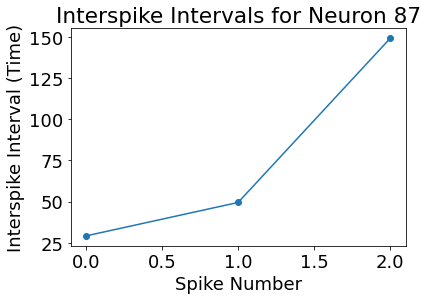

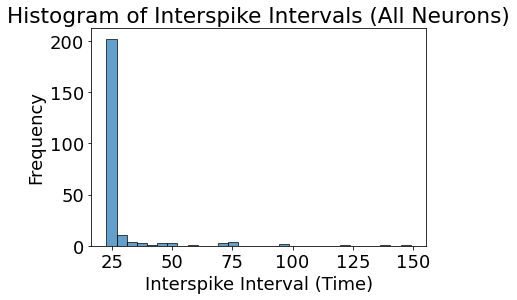

In [15]:
import matplotlib.pyplot as plt

# Calculate interspike intervals (ISIs) for each neuron
interspike_intervals = {neuron: [] for neuron in neuron_spike_times}

for neuron, times in neuron_spike_times.items():
    if len(times) > 1:  # Need at least two spikes to calculate ISI
        interspike_intervals[neuron] = [times[i+1] - times[i] for i in range(len(times)-1)]

# Plot ISIs for a specific neuron (e.g., Neuron 0)
neuron_to_plot = 87
if interspike_intervals[neuron_to_plot]:
    plt.figure()
    plt.plot(interspike_intervals[neuron_to_plot], marker='o')
    plt.title(f"Interspike Intervals for Neuron {neuron_to_plot}")
    plt.xlabel("Spike Number")
    plt.ylabel("Interspike Interval (Time)")
    plt.show()
else:
    print(f"Neuron {neuron_to_plot} has no ISIs to plot.")

# Histogram of ISIs for all neurons
all_isis = [isi for neuron_isis in interspike_intervals.values() for isi in neuron_isis]
if all_isis:
    plt.figure()
    plt.hist(all_isis, bins=30, alpha=0.7, edgecolor='k')
    plt.title("Histogram of Interspike Intervals (All Neurons)")
    plt.xlabel("Interspike Interval (Time)")
    plt.ylabel("Frequency")
    plt.show()
else:
    print("No ISIs found across neurons to plot.")


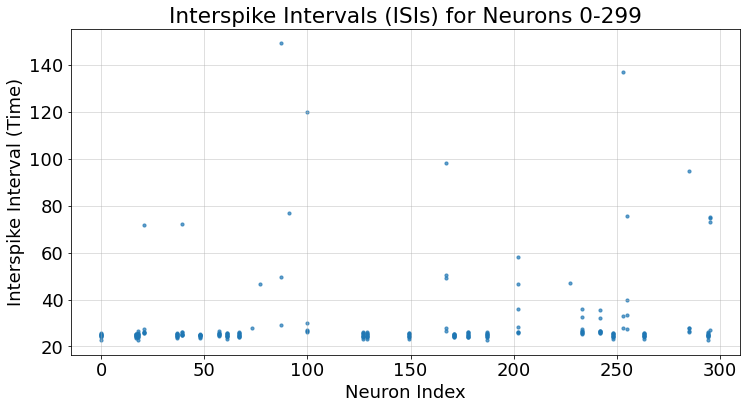

In [16]:
import matplotlib.pyplot as plt

# Prepare data for the scatter plot
x_neurons = []
y_isis = []

for neuron, isis in interspike_intervals.items():
    x_neurons.extend([neuron] * len(isis))  # Repeat neuron index for each ISI
    y_isis.extend(isis)  # Add all ISIs for this neuron

# Scatter plot
plt.figure(figsize=(12, 6))
plt.scatter(x_neurons, y_isis, alpha=0.7, s=10)  # Small points for better clarity
plt.title("Interspike Intervals (ISIs) for Neurons 0-299")
plt.xlabel("Neuron Index")
plt.ylabel("Interspike Interval (Time)")
plt.grid(alpha=0.5)
plt.show()


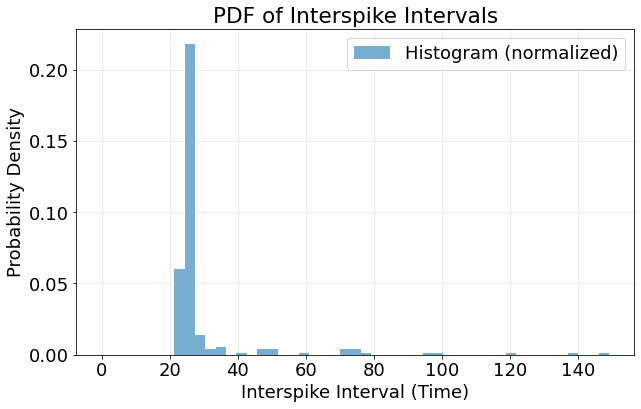

Total area under histogram: 1.0


In [17]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde

# Assume `interspike_intervals` is a dictionary with neuron indices as keys and lists of ISIs as values
all_isis = []
for isis in interspike_intervals.values():
    all_isis.extend(isis)  # Aggregate all ISIs across neurons

# Convert ISIs to a numpy array
all_isis = np.array(all_isis)

# Generate histogram and normalize to form a PDF
bin_edges = np.linspace(0, np.max(all_isis), 50)  # Adjust bins as needed
hist, bin_edges = np.histogram(all_isis, bins=bin_edges, density=True)

# Smooth PDF using Kernel Density Estimation (KDE)
kde = gaussian_kde(all_isis)
x_vals = np.linspace(0, np.max(all_isis), 500)
pdf_vals = kde(x_vals)

# Plot the PDF
plt.figure(figsize=(10, 6))
plt.hist(all_isis, bins=bin_edges, density=True, alpha=0.6, label='Histogram (normalized)')
plt.title("PDF of Interspike Intervals")
plt.xlabel("Interspike Interval (Time)")
plt.ylabel("Probability Density")
plt.legend()
plt.grid(alpha=0.3)
plt.show()
# Histogram computation with density=True
hist, bin_edges = np.histogram(all_isis, bins=50, density=True)

# Calculate the total area under the histogram
bin_widths = np.diff(bin_edges)  # Calculate the width of each bin
total_area = np.sum(hist * bin_widths)  # Sum of (height * width) for each bar

print(f"Total area under histogram: {total_area}")  # Should print approximately 1


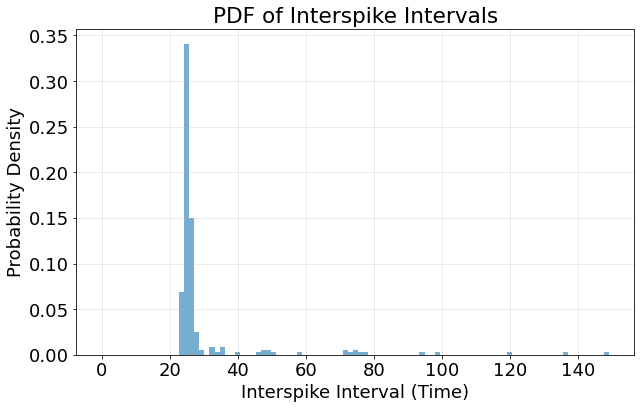

Total area under histogram: 1.0
Width of each bin: [1.50562868 1.50562868 1.50562868 1.50562868 1.50562868 1.50562868
 1.50562868 1.50562868 1.50562868 1.50562868 1.50562868 1.50562868
 1.50562868 1.50562868 1.50562868 1.50562868 1.50562868 1.50562868
 1.50562868 1.50562868 1.50562868 1.50562868 1.50562868 1.50562868
 1.50562868 1.50562868 1.50562868 1.50562868 1.50562868 1.50562868
 1.50562868 1.50562868 1.50562868 1.50562868 1.50562868 1.50562868
 1.50562868 1.50562868 1.50562868 1.50562868 1.50562868 1.50562868
 1.50562868 1.50562868 1.50562868 1.50562868 1.50562868 1.50562868
 1.50562868 1.50562868 1.50562868 1.50562868 1.50562868 1.50562868
 1.50562868 1.50562868 1.50562868 1.50562868 1.50562868 1.50562868
 1.50562868 1.50562868 1.50562868 1.50562868 1.50562868 1.50562868
 1.50562868 1.50562868 1.50562868 1.50562868 1.50562868 1.50562868
 1.50562868 1.50562868 1.50562868 1.50562868 1.50562868 1.50562868
 1.50562868 1.50562868 1.50562868 1.50562868 1.50562868 1.50562868
 1.50562868

In [18]:
# Generate histogram and normalize to form a PDF with smaller bins
bin_edges = np.linspace(0, np.max(all_isis), 100)  # Increase the number of bins for finer granularity
hist, bin_edges = np.histogram(all_isis, bins=bin_edges, density=True)


# Plot the PDF
plt.figure(figsize=(10, 6))
plt.hist(all_isis, bins=bin_edges, density=True, alpha=0.6)

plt.title("PDF of Interspike Intervals")
plt.xlabel("Interspike Interval (Time)")
plt.ylabel("Probability Density")
plt.grid(alpha=0.3)
plt.show()

# Calculate the total area under the histogram
bin_widths = np.diff(bin_edges)  # Calculate the width of each bin
total_area = np.sum(hist * bin_widths)  # Sum of (height * width) for each bar

print(f"Total area under histogram: {total_area}")  # Should print approximately 1
# Calculate the bin widths
bin_widths = np.diff(bin_edges)  # Difference between consecutive bin edges
print(f"Width of each bin: {bin_widths}")


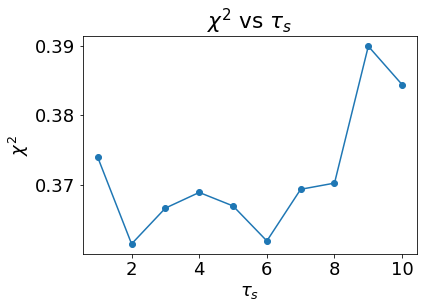

In [19]:
# Define the range of tau_s values
tau_s_values = np.arange(1, 11, 1)  # Values from 0 to 10 inclusive
chi_sq_values = []

# Loop over different values of tau_s
for tau_s in tau_s_values:
    # Reinitialize initial conditions for each tau_s run
    v_init = np.random.normal(-70, 5, size=(N))
    u_init = np.zeros(N)
    s_init = np.zeros(N)
    p_init = np.zeros(N)
    
    t_all = np.array([t0])
    y_0 = np.concatenate([v_init, u_init, s_init, p_init])
    y_all = np.reshape(y_0, (y_0.shape[0], 1))
    
    spike_times = np.zeros((M, 2))
    spikeCounter = 0
    i = 0
    t0 = 0  # Reset simulation start time

    # Simulation loop with new tau_s
    while i < M and t0 < T:
        y0 = np.concatenate([v_init, u_init, s_init, p_init])  

        # Use solve_ivp with current tau_s
        sol_v = solve_ivp(dxdt, [t0, T], y0, args=(k, a, b, I, Esyn, J, tau_s), dense_output=True, 
                          events=v_spike, rtol=1e-8)

        t_end = sol_v.t[-1]
        steps = max([2, int((t_end - t0) / dt)])
        t = np.linspace(t0, t_end, steps)
        y = sol_v.sol(t)
        
        t_all = np.concatenate([t_all, t[:-1]], axis=0)
        y_all = np.concatenate([y_all, y[:, :-1]], axis=1)

        t0 = t_end
        v_init = y[:N, -1]
        u_init = y[N:2*N, -1]
        s_init = y[2*N:3*N, -1]
        p_init = y[3*N:4*N, -1]

        if len(sol_v.t_events[0]) > 0:
            spike = v_init.argmax()
            v_init[spike] = v_reset
            u_init[spike] += d
            p_init += 1 / (tau_s * N) if tau_s > 0 else 0  # Avoid division by zero for tau_s=0
            
            spike_times[spikeCounter, :] = [t0, spike]
            spikeCounter = spikeCounter + 1
            i += 1

    # Compute chi_sq for current tau_s
    data = y_all[:N, :]
    chi_sq = compute_chi(data)
    chi_sq_values.append(chi_sq)

# Plotting the results
plt.figure()
plt.plot(tau_s_values, chi_sq_values, marker='o', linestyle='-')
plt.xlabel(r'$\tau_s$')
plt.ylabel(r'$\chi^2$')
plt.title(r'$\chi^2$ vs $\tau_s$')
plt.show()


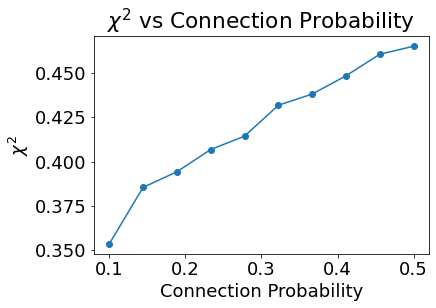

In [20]:
# Define different connectivity parameters for g
connection_probs = np.linspace(0.1, 0.5, 10)  # Vary connection probability from 0.1 to 0.5
chi_sq_values = []

# Loop over different values of connection probability for g
for conn_prob in connection_probs:
    # Initialize synaptic coupling matrix with new connection probability
    g = np.zeros((N, N))
    for j in range(N):
        for i in range(N):
            if i != j:  # Avoid self-connections
                if np.random.rand() < conn_prob:
                    g[j, i] = np.random.uniform(0.25, 0.5)  # Set random connection strength

    # Reinitialize initial conditions for each g matrix run
    v_init = np.random.normal(-70, 5, size=(N))
    u_init = np.zeros(N)
    s_init = np.zeros(N)
    p_init = np.zeros(N)
    
    t_all = np.array([t0])
    y_0 = np.concatenate([v_init, u_init, s_init, p_init])
    y_all = np.reshape(y_0, (y_0.shape[0], 1))
    
    spike_times = np.zeros((M, 2))
    spikeCounter = 0
    i = 0
    t0 = 0  # Reset simulation start time

    # Simulation loop with the current synaptic coupling matrix g
    while i < M and t0 < T:
        y0 = np.concatenate([v_init, u_init, s_init, p_init])  

        # Use solve_ivp with current g matrix
        sol_v = solve_ivp(dxdt, [t0, T], y0, args=(k, a, b, I, Esyn, J, tauS), dense_output=True, 
                          events=v_spike, rtol=1e-8)

        t_end = sol_v.t[-1]
        steps = max([2, int((t_end - t0) / dt)])
        t = np.linspace(t0, t_end, steps)
        y = sol_v.sol(t)
        
        t_all = np.concatenate([t_all, t[:-1]], axis=0)
        y_all = np.concatenate([y_all, y[:, :-1]], axis=1)

        t0 = t_end
        v_init = y[:N, -1]
        u_init = y[N:2*N, -1]
        s_init = y[2*N:3*N, -1]
        p_init = y[3*N:4*N, -1]

        if len(sol_v.t_events[0]) > 0:
            spike = v_init.argmax()
            v_init[spike] = v_reset
            u_init[spike] += d
            p_init += 1 / (tauS * N) if tauS > 0 else 0  # Avoid division by zero if tauS=0
            
            spike_times[spikeCounter, :] = [t0, spike]
            spikeCounter = spikeCounter + 1
            i += 1

    # Compute chi_sq for the current g matrix
    data = y_all[:N, :]
    chi_sq = compute_chi(data)
    chi_sq_values.append(chi_sq)

# Plotting the results
plt.figure()
plt.plot(connection_probs, chi_sq_values, marker='o', linestyle='-')
plt.xlabel('Connection Probability')
plt.ylabel(r'$\chi^2$')
plt.title(r'$\chi^2$ vs Connection Probability')
plt.show()


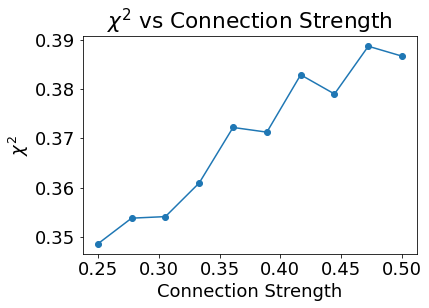

In [21]:
# Define different connectivity parameters for g
connection_strengths = np.linspace(0.25, 0.5, 10)  # Vary connection strength from 0.25 to 0.5
chi_sq_values = []

# Loop over different values of connection strength for g
for conn_strength in connection_strengths:
    # Initialize synaptic coupling matrix with new connection strength
    g = np.zeros((N, N))
    for j in range(N):
        for i in range(N):
            if i != j:  # Avoid self-connections
                if np.random.rand() < 40/300:  # Fixed probability for connection, e.g., 0.3
                    g[j, i] = conn_strength  # Set connection to the current strength value

    # Reinitialize initial conditions for each g matrix run
    v_init = np.random.normal(-70, 1, size=(N))
    u_init = np.zeros(N)
    s_init = np.zeros(N)
    p_init = np.zeros(N)
    
    t_all = np.array([t0])
    y_0 = np.concatenate([v_init, u_init, s_init, p_init])
    y_all = np.reshape(y_0, (y_0.shape[0], 1))
    
    spike_times = np.zeros((M, 2))
    spikeCounter = 0
    i = 0
    t0 = 0  # Reset simulation start time

    # Simulation loop with the current synaptic coupling matrix g
    while i < M and t0 < T:
        y0 = np.concatenate([v_init, u_init, s_init, p_init])  

        # Use solve_ivp with current g matrix
        sol_v = solve_ivp(dxdt, [t0, T], y0, args=(k, a, b, I, Esyn, J, tauS), dense_output=True, 
                          events=v_spike, rtol=1e-8)

        t_end = sol_v.t[-1]
        steps = max([2, int((t_end - t0) / dt)])
        t = np.linspace(t0, t_end, steps)
        y = sol_v.sol(t)
        
        t_all = np.concatenate([t_all, t[:-1]], axis=0)
        y_all = np.concatenate([y_all, y[:, :-1]], axis=1)

        t0 = t_end
        v_init = y[:N, -1]
        u_init = y[N:2*N, -1]
        s_init = y[2*N:3*N, -1]
        p_init = y[3*N:4*N, -1]

        if len(sol_v.t_events[0]) > 0:
            spike = v_init.argmax()
            v_init[spike] = v_reset
            u_init[spike] += d
            p_init += 1 / (tauS * N) if tauS > 0 else 0  # Avoid division by zero if tauS=0
            
            spike_times[spikeCounter, :] = [t0, spike]
            spikeCounter = spikeCounter + 1
            i += 1

    # Compute chi_sq for the current g matrix
    data = y_all[:N, :]
    chi_sq = compute_chi(data)
    chi_sq_values.append(chi_sq)

# Plotting the results
plt.figure()
plt.plot(connection_strengths, chi_sq_values, marker='o', linestyle='-')
plt.xlabel('Connection Strength')
plt.ylabel(r'$\chi^2$')
plt.title(r'$\chi^2$ vs Connection Strength')
plt.show()


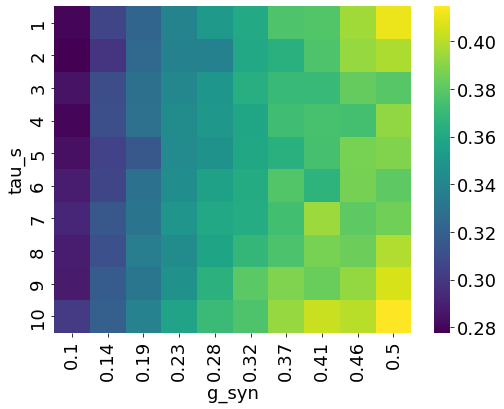

In [22]:
tau_s_values = np.arange(1, 11, 1)  
g_syn_values = np.linspace(0.1, 0.5, 10)  

chi_sq_matrix = np.zeros((len(tau_s_values), len(g_syn_values)))

for i, tau_s in enumerate(tau_s_values):
    for j, g_syn in enumerate(g_syn_values):
        g = np.zeros((N, N))
        for row in range(N):
            for col in range(N):
                if row != col:  
                    if np.random.rand() < connection_probability:
                        g[row, col] = np.random.uniform(g_syn - 0.1, g_syn + 0.1)  

        v_init = np.random.normal(-70, 5, size=(N))
        u_init = np.zeros(N)
        s_init = np.zeros(N)
        p_init = np.zeros(N)
        
        t_all = np.array([t0])
        y_0 = np.concatenate([v_init, u_init, s_init, p_init])
        y_all = np.reshape(y_0, (y_0.shape[0], 1))
        
        spike_times = np.zeros((M, 2))
        spikeCounter = 0
        t0 = 0  
        i_step = 0

        while i_step < M and t0 < T:
            y0 = np.concatenate([v_init, u_init, s_init, p_init])  

            
            sol_v = solve_ivp(dxdt, [t0, T], y0, args=(k, a, b, I, Esyn, J, tau_s), dense_output=True, 
                              events=v_spike, rtol=1e-8)

            t_end = sol_v.t[-1]
            steps = max([2, int((t_end - t0) / dt)])
            t = np.linspace(t0, t_end, steps)
            y = sol_v.sol(t)
            
            t_all = np.concatenate([t_all, t[:-1]], axis=0)
            y_all = np.concatenate([y_all, y[:, :-1]], axis=1)

            t0 = t_end
            v_init = y[:N, -1]
            u_init = y[N:2*N, -1]
            s_init = y[2*N:3*N, -1]
            p_init = y[3*N:4*N, -1]

            if len(sol_v.t_events[0]) > 0:
                spike = v_init.argmax()
                v_init[spike] = v_reset
                u_init[spike] += d
                p_init += 1 / (tau_s * N) if tau_s > 0 else 0
                
                spike_times[spikeCounter, :] = [t0, spike]
                spikeCounter = spikeCounter + 1
                i_step += 1

        data = y_all[:N, :]
        chi_sq = compute_chi(data)
        chi_sq_matrix[i, j] = chi_sq

plt.figure(figsize=(8, 6))
sns.heatmap(chi_sq_matrix, xticklabels=np.round(g_syn_values, 2), yticklabels=tau_s_values, cmap='viridis')
plt.xlabel('g_syn')
plt.ylabel('tau_s')
plt.show()


Average number of connections per neuron: 299.0
Connectivity Matrix g [[0.         0.36292735 0.30422096 ... 0.43976837 0.23871736 0.34303392]
 [0.17090422 0.         0.30323812 ... 0.14331204 0.38482852 0.4157985 ]
 [0.42974362 0.3160908  0.         ... 0.06724938 0.44582085 0.27171807]
 ...
 [0.4537874  0.06455965 0.21337927 ... 0.         0.32264052 0.11782589]
 [0.30513452 0.49427847 0.12942729 ... 0.37765005 0.         0.08254897]
 [0.31619507 0.08787106 0.49874807 ... 0.37654122 0.18041027 0.        ]]
Average value of matrix g= 0.27456597161269375


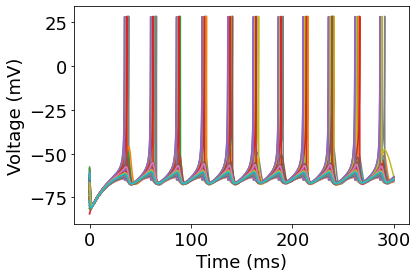

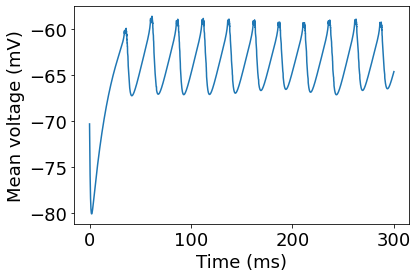

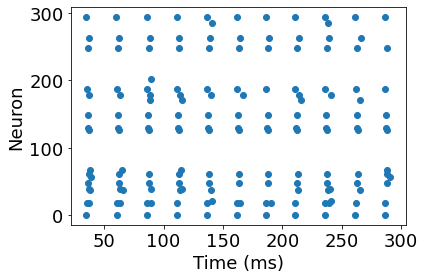

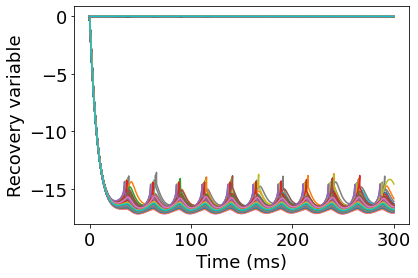

In [23]:
# Making neuron sparsely connected for second order synaptic term
# Has identical code to paper except different synaptic term (2nd order given by Aine)
# Changed the synaptic coupling to be probabilistic
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
import seaborn as sns
import scipy.stats as stats
import random

np.random.seed(101)

N = 300
T = 300
M = 50000
dt = 0.005
t0 = 0

k = 1
a = 0.1
b = 0.26
c = -65
d = -1
v_reset = c
v_thresh = 30

Esyn = -70
tauS = 3.043043043043043

J = np.random.normal(0, 0.25, size=(N))

I0 = 0.15
delta = 0.02  
#I = stats.cauchy.rvs(loc=I0, scale=delta, size=(N))
I = 0.15
# Define desired average number of connections
Avg_Connections = 40
connection_probability = Avg_Connections / N

# Initialize the synaptic coupling matrix
g = np.zeros((N, N))

# # Sparsely connected networks with probabilistic connections
# for j in range(N):
#     for i in range(N):
#         if i != j:  # Avoid self-connections
#             if np.random.rand() < connection_probability:
#                 g[j, i] = np.random.uniform(0.25, 0.5)  # Set random connection strength 

#All-to-all connectivity
g = np.random.uniform(0.05, 0.5, size=(N, N))
np.fill_diagonal(g, 0)  # Set diagonal to zero to avoid self-connections



v_init = np.random.normal(-70, 5, size=(N))
u_init = np.zeros(N)
s_init = np.zeros(N)
p_init = np.zeros(N)

t_all = np.array([t0])
y_0 = np.concatenate([v_init, u_init, s_init, p_init])
y_all = np.reshape(y_0, (y_0.shape[0], 1))

spike_times = np.zeros((M, 2))
spikeCounter = 0
i = 0

def dxdt(t, x, k, a, b, I, Esyn, J, tauS):
    v = x[:N]
    u = x[N:2*N]
    s = x[2*N:3*N]
    p = x[3*N:4*N]
    
    dvdt = k * (0.04 * v**2 + 5 * v + 140 - u + I) + J - (v - Esyn) * np.dot(g,s)
    dudt = k * a * (b * v - u)
    dsdt = -s / tauS + p / tauS
    dpdt = -p / tauS
    
    return np.concatenate([dvdt, dudt, dsdt, dpdt])

# Spike event
def v_spike(t, x, k, a, b, I, Esyn, J, tauS):
    return x[:N].max() - v_thresh
v_spike.terminal = True
v_spike.direction = 1

# Set up spike time vector
spike_times = np.zeros((M, 2))
spikeCounter = 0    
i = 0

# Simulation loop
while i < M and t0 < T:
    y0 = np.concatenate([v_init, u_init, s_init, p_init])  
   
    sol_v = solve_ivp(dxdt, [t0, T], y0, args=(k, a, b, I, Esyn, J, tauS), dense_output=True, 
                      events=v_spike, rtol=1e-8)
    
    t_end = sol_v.t[-1]
    steps = max([2, int((t_end - t0) / dt)])
    t = np.linspace(t0, t_end, steps)
    y = sol_v.sol(t)
    
    t_all = np.concatenate([t_all, t[:-1]], axis=0)
    y_all = np.concatenate([y_all, y[:, :-1]], axis=1)
    
    t0 = t_end
    v_init = y[:N, -1]
    u_init = y[N:2*N, -1]
    s_init = y[2*N:3*N, -1]
    p_init = y[3*N:4*N, -1]
    
    if len(sol_v.t_events[0]) > 0:
        spike = v_init.argmax()
        v_init[spike] = v_reset
        u_init[spike] += d
        p_init += 1 / (tauS * N)
        
        spike_times[spikeCounter, :] = [t0, spike]
        spikeCounter = spikeCounter + 1
        i += 1

colours = sns.color_palette('deep')
font = {'family': 'Times', 'weight': 'normal', 'size': 18}
plt.rc('font', **font)

plt.figure()
plt.plot(t_all, y_all[:N, :].T)
plt.xlabel('Time (ms)')
plt.ylabel('Voltage (mV)')

plt.figure()
plt.plot(t_all, y_all[:N, :].mean(axis=0))
plt.xlabel('Time (ms)')
plt.ylabel('Mean voltage (mV)')

spike_times = spike_times[:spikeCounter, :]
plt.figure()
plt.scatter(spike_times[:, 0], spike_times[:, 1])
plt.xlabel('Time (ms)')
plt.ylabel('Neuron')

plt.figure()
plt.plot(t_all, y_all[N:, :].T)
plt.xlabel('Time (ms)')
plt.ylabel('Recovery variable')



# Count the number of non-zero entries in each row
connections_per_neuron = np.count_nonzero(g, axis=1)

# Calculate the average number of connections per neuron
average_connections = np.mean(connections_per_neuron)

print(f"Average number of connections per neuron: {average_connections}")
print("Connectivity Matrix g", g)
print("Average value of matrix g=", np.mean(g))

In [ ]:
tau_s_values = np.arange(1, 11, 1)  
g_syn_values = np.linspace(0.1, 0.5, 10)  

chi_sq_matrix = np.zeros((len(tau_s_values), len(g_syn_values)))

for i, tau_s in enumerate(tau_s_values):
    for j, g_syn in enumerate(g_syn_values):
        g = np.zeros((N, N))
        for row in range(N):
            for col in range(N):
                if row != col:  
                    if np.random.rand() < connection_probability:
                        g[row, col] = np.random.uniform(g_syn - 0.1, g_syn + 0.1)  

        v_init = np.random.normal(-70, 5, size=(N))
        u_init = np.zeros(N)
        s_init = np.zeros(N)
        p_init = np.zeros(N)
        
        t_all = np.array([t0])
        y_0 = np.concatenate([v_init, u_init, s_init, p_init])
        y_all = np.reshape(y_0, (y_0.shape[0], 1))
        
        spike_times = np.zeros((M, 2))
        spikeCounter = 0
        t0 = 0  
        i_step = 0

        while i_step < M and t0 < T:
            y0 = np.concatenate([v_init, u_init, s_init, p_init])  

            
            sol_v = solve_ivp(dxdt, [t0, T], y0, args=(k, a, b, I, Esyn, J, tau_s), dense_output=True, 
                              events=v_spike, rtol=1e-8)

            t_end = sol_v.t[-1]
            steps = max([2, int((t_end - t0) / dt)])
            t = np.linspace(t0, t_end, steps)
            y = sol_v.sol(t)
            
            t_all = np.concatenate([t_all, t[:-1]], axis=0)
            y_all = np.concatenate([y_all, y[:, :-1]], axis=1)

            t0 = t_end
            v_init = y[:N, -1]
            u_init = y[N:2*N, -1]
            s_init = y[2*N:3*N, -1]
            p_init = y[3*N:4*N, -1]

            if len(sol_v.t_events[0]) > 0:
                spike = v_init.argmax()
                v_init[spike] = v_reset
                u_init[spike] += d
                p_init += 1 / (tau_s * N) if tau_s > 0 else 0
                
                spike_times[spikeCounter, :] = [t0, spike]
                spikeCounter = spikeCounter + 1
                i_step += 1

        data = y_all[:N, :]
        chi_sq = compute_chi(data)
        chi_sq_matrix[i, j] = chi_sq

plt.figure(figsize=(8, 6))
sns.heatmap(chi_sq_matrix, xticklabels=np.round(g_syn_values, 2), yticklabels=tau_s_values, cmap='viridis')
plt.xlabel('g_syn')
plt.ylabel('tau_s')
plt.show()


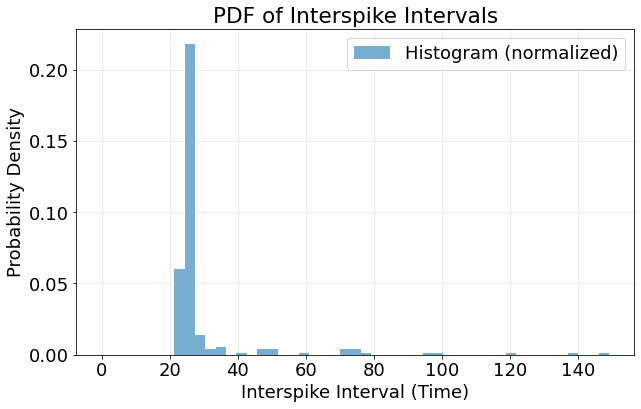

Total area under histogram: 1.0


In [24]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde

# Assume `interspike_intervals` is a dictionary with neuron indices as keys and lists of ISIs as values
all_isis = []
for isis in interspike_intervals.values():
    all_isis.extend(isis)  # Aggregate all ISIs across neurons

# Convert ISIs to a numpy array
all_isis = np.array(all_isis)

# Generate histogram and normalize to form a PDF
bin_edges = np.linspace(0, np.max(all_isis), 50)  # Adjust bins as needed
hist, bin_edges = np.histogram(all_isis, bins=bin_edges, density=True)

# Smooth PDF using Kernel Density Estimation (KDE)
kde = gaussian_kde(all_isis)
x_vals = np.linspace(0, np.max(all_isis), 500)
pdf_vals = kde(x_vals)

# Plot the PDF
plt.figure(figsize=(10, 6))
plt.hist(all_isis, bins=bin_edges, density=True, alpha=0.6, label='Histogram (normalized)')
plt.title("PDF of Interspike Intervals")
plt.xlabel("Interspike Interval (Time)")
plt.ylabel("Probability Density")
plt.legend()
plt.grid(alpha=0.3)
plt.show()
# Histogram computation with density=True
hist, bin_edges = np.histogram(all_isis, bins=50, density=True)

# Calculate the total area under the histogram
bin_widths = np.diff(bin_edges)  # Calculate the width of each bin
total_area = np.sum(hist * bin_widths)  # Sum of (height * width) for each bar

print(f"Total area under histogram: {total_area}")  # Should print approximately 1
